# Barycenter method - recursive and batch versions 

## Setup

In [6]:
!pip install --force-reinstall pybary matplotlib

Error processing line 1 of /home/brunolnetto/.local/lib/python3.8/site-packages/reactpy_jupyter.pth:

  Traceback (most recent call last):
    File "/usr/lib/python3.8/site.py", line 175, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "/home/brunolnetto/.local/lib/python3.8/site-packages/reactpy_jupyter/__init__.py", line 7, in <module>
      from . import jupyter_server_extension
    File "/home/brunolnetto/.local/lib/python3.8/site-packages/reactpy_jupyter/jupyter_server_extension.py", line 6, in <module>
      from appdirs import user_data_dir
  ModuleNotFoundError: No module named 'appdirs'

Remainder of file ignored
Defaulting to user installation because normal site-packages is not writeable
  Using cached pybary-0.1.9-py3-none-any.whl (4.0 kB)
  Using cached ipykernel-6.23.3-py3-none-any.whl (152 kB)
  Using cached ipython-8.12.2-py3-none-any.whl (797 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 3.1 MB/s eta 0:00:00
  Using cac

  Using cached executing-1.2.0-py2.py3-none-any.whl (24 kB)
  Using cached asttokens-2.2.1-py2.py3-none-any.whl (26 kB)
  Using cached pure_eval-0.2.2-py3-none-any.whl (11 kB)
  Attempting uninstall: traitlets
    Found existing installation: traitlets 5.9.0
    Uninstalling traitlets-5.9.0:
      Successfully uninstalled traitlets-5.9.0
  Attempting uninstall: tornado
    Found existing installation: tornado 6.3.2
    Uninstalling tornado-6.3.2:
      Successfully uninstalled tornado-6.3.2
  Attempting uninstall: pyzmq
    Found existing installation: pyzmq 25.1.0
    Uninstalling pyzmq-25.1.0:
      Successfully uninstalled pyzmq-25.1.0
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 3.0.38
    Uninstalling prompt-toolkit-3.0.38:
      Successfully uninstalled prompt-toolkit-3.0.38
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.1
    Uninstalling numpy-1.24.1:
      Successfully uninstalled numpy-1.24.1
  Attempting un

In [1]:
# Add pybary to os path 
import os, sys

currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)

sys.path.append(parentdir+'/pybary')

In [1]:
!pip show pybary

Name: pybary
Version: 0.1.9
Summary: Barycenter method in python
Home-page: https://pypi.org/project/pybary/
Author: Bruno Peixoto
Author-email: brunolnetto@gmail.com
License: MIT
Location: /home/brunolnetto/.local/lib/python3.8/site-packages
Requires: ipykernel, ipython, jupyter-core, matplotlib, numpy, seaborn
Required-by: 


In [4]:
import pybary

In [5]:
# Main imports
import numpy as np
from numpy import power, array, exp, zeros, append, arange
from numpy.random import normal
from numpy.linalg import norm
from functools import reduce
import matplotlib.pyplot as plt
import pylab

from IPython.display import display
from ipywidgets import interactive, FloatSlider, IntSlider
from collections import namedtuple

from pybary import bary_batch, bary_recursive, bary_recur_formula


## Hyperparameters

In [6]:
# Oracle function
oracle = lambda x: norm(x)

# Hyperparameters
nu = 5
sigma = 0.5
zeta = 0
lambda_ = 1

## Batch version

In [7]:
# Batch setup

# Points for batch barycenter version
mu_x = 0
sigma_x = 1
size_batch = [100, 2]

xs = normal(mu_x, sigma_x, size_batch)

# Batch run
xhat_batch = bary_batch(oracle, xs, nu)

# Results
print(xhat_batch)

[[ 0.00720572 -0.01487218]]


## Recursive version

In [15]:
# Recursive setup

# Initial point
x0 = array([1, 1])

# Iteration cardinality
iterations = 100

# Recursive run
xhat_recursive = bary_recursive(oracle, x0, nu, sigma, zeta, lambda_, iterations)

print(xhat_recursive)


[[-0.00025283  0.0361197 ]]


# Iterative recursive version

In [8]:
def bell_fun(x, center_, sigma_):
    return (1/np.sqrt(2*np.pi))*np.exp(-norm(x-center_)/sigma_)

sum_map=lambda a,b: a+b

def hills(x, centers_, sigmas_, weights_):
    return reduce(
        sum_map, 
        map(\
            lambda sigma_center: sigma_center[2]*bell_fun(x, sigma_center[0], sigma_center[1]), \
            zip(centers_, sigmas_, weights_)
        )
    )

def valleys(x, centers_, sigmas_, weights_):
    return -hills(x, centers_, sigmas_, weights_)

In [9]:
weights=[
    1, 
    2,
    1
]

sigmas=[
    0.5, 
    2,
    1
]

centers=[
    np.array([1, 0]),
    np.array([0, 1]),
    np.array([0, 0])
]

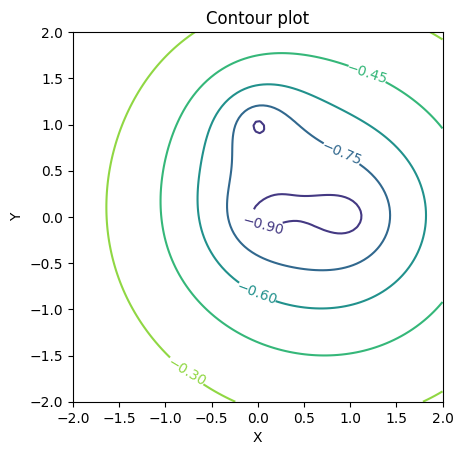

In [10]:
import pylab
import numpy as np

n=100

# Oracle function
oracle_valley = lambda x: valleys(x, centers, sigmas, weights)
oracle_hill = lambda x: hills(x, centers, sigmas, weights)

x_min=-2
x_max=2
y_min=-2
y_max=2

X=np.linspace(x_min, x_max, n)
Y=np.linspace(y_min, y_max, n)

# Z values as a matrix
Z = np.ndarray((len(X),len(Y)))

for i in range(0, n):
    for j in range(0, n):
        Z[i][j] = oracle_valley([X[i], Y[j]])

fig = plt.figure()
ax = plt.gca()

ax.set_aspect('equal', adjustable='box')

# Set the x axis and y axis limits
pylab.xlim([x_min,x_max])
pylab.ylim([y_min,y_max])

# Provide a title for the contour plot
plt.title('Contour plot')

# Set x axis label for the contour plot
plt.xlabel('X')

# Set y axis label for the contour plot
plt.ylabel('Y')

# Create contour lines for the Hyperbolic Paraboloid using matplotlib.pyplot module
contours = plt.contour(X, Y, Z)

# Display z values on contour lines
plt.clabel(contours, inline=1, fontsize=10)

plt.show()


In [11]:
# Initial iteration point
x0 = array([1, 1])

oracle_fun=oracle_valley

x_min_=-2
x_max_=2
y_min_=-2
y_max_=2

# Recursion object
RecurResultsProps = ["steps", "ms", "xhats", "oracle"]
RecurResults = namedtuple("RecurResults", RecurResultsProps)

# Instance average object
instanceAverageResultsProps = ["steps", "ms", "xhats", "oracle"]
instanceAverageResults = namedtuple("instanceAverageResults", RecurResultsProps)

# Hyperparameters object
hyperparametersProps = ["nu", "sigma", "zeta", "lambda_"]
hyperparameters = namedtuple("hyperparameters", hyperparametersProps)

def update_mean(curr_count, curr_mean, x):
    return curr_count*curr_mean/(curr_count+1) +  array(x)/(curr_count+1)

def bary_recur_(oracle_fun, x0, nu, sigma, zeta, lambda_, iterations):
    # Necessary 
    xhat_1 = x0
    m_1 = 0
    card_x = (len(x0), 1)

    deltax_1 = zeros(card_x)

    ms = []
    xhats = []
    solution_is_found = False
    
    # Recursive run
    i = 1
    while not solution_is_found:
        z = normal(zeta * deltax_1, sigma).T

        x = xhat_1 + z
        m, xhat = bary_recur_formula(m_1, xhat_1, x, oracle_fun, nu, lambda_)
        
        ms.append(m)
        xhats.append(list(xhat[0]))

        # Update previous variables
        m_1 = m
        xhat_1 = xhat
        deltax_1 = xhat - xhat_1

        solution_is_found = i >= iterations
        i = i + 1
    
    return ms, xhats    
    
def do_recur(nu, sigma, zeta, lambda_, iterations):    
    # It assumes, there is a vairable called "oracle_fun"
    ms, xhats = bary_recur_(oracle_fun, x0, nu, sigma, zeta, lambda_, iterations)
    
    RecurResults.steps = arange(start=1, stop=iterations+1)
    RecurResults.ms = array(ms)
    RecurResults.xhats = array(xhats)
    RecurResults.oracle = oracle_fun
    
    return RecurResults

def plot_average(steps, ms, xhats, hyperparameters):
    plt.stem(steps, ms)
    plt.show()

    fig, axs = plt.subplots(1, 2)
    
    title_regex = '$\\nu = {}$, $\\sigma = {}$, $\\zeta = {}$, $\\lambda = {}$'
    title_str = title_regex.format(
        hyperparameters.nu, 
        hyperparameters.sigma,
        hyperparameters.zeta,
        hyperparameters.lambda_
    )
    plt.suptitle(title_str)
    
    axs[0].stem(steps, xhats[:,[0]])
    axs[1].stem(steps, xhats[:,[1]])

def plot_oracle(oracle, x_min, x_max, y_min, y_max, n, points=None):
    
    X=np.linspace(x_min, x_max, n)
    Y=np.linspace(y_min, y_max, n)
    # Z values as a matrix
    Z = np.ndarray((len(X),len(Y)))
    for i in range(0, n):
        for j in range(0, n):
            Z[i][j] = oracle([X[i], Y[j]])
    
    fig = plt.figure()
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    # Set the x axis and y axis limits
    pylab.xlim([x_min,x_max])
    pylab.ylim([y_min,y_max])
    # Provide a title for the contour plot
    plt.title('Contour plot')
    # Set x axis label for the contour plot
    plt.xlabel('X')
    # Set y axis label for the contour plot
    plt.ylabel('Y')
    # Create contour lines for the Hyperbolic Paraboloid using matplotlib.pyplot module
    contours = plt.contour(X, Y, Z)
    
    # Plot additional points if provided
    if points is not None:
        points = np.array(points)
        plt.scatter(points[:, 0], points[:, 1], color='red', label='Barycenters')
        plt.legend()
    
    # Display z values on contour lines
    plt.clabel(contours, inline=1, fontsize=10)
    

def do_plot(plotResults, hyperparameters):
    # Plot multi-images
    steps = plotResults.steps
    ms = plotResults.ms
    xhats = plotResults.xhats
    oracle = plotResults.oracle
    
    x_min=plotResults.x_min
    x_max=plotResults.x_max
    y_min=plotResults.y_min
    y_max=plotResults.y_max
    
    plot_average(steps, ms, xhats, hyperparameters)
    plot_oracle(oracle, x_min, x_max, y_min, y_max, n, points=xhats)

    plt.show()

def handle_event(nu, sigma, zeta, lambda_, iterations, instances):
    """
    Process events from the ipywidgets.interactive handler.
       
    Argument names in the event handler must match the keys in the "interactive" call (below).       
    """
    
    hyperparameters.nu = nu
    hyperparameters.sigma = sigma
    hyperparameters.zeta = zeta
    hyperparameters.lambda_ = lambda_
    
    card_m = (1, iterations)
    card_xhat = (iterations, len(x0))
    
    instanceAverageResults.ms = zeros(card_m);
    instanceAverageResults.xhats = zeros(card_xhat);
    instanceAverageResults.finals = []
    instanceAverageResults.x_min = 0
    instanceAverageResults.x_max = 0
    instanceAverageResults.y_min = 0
    instanceAverageResults.y_max = 0
    
    x_mins=[]
    x_maxs=[]
    y_mins=[]
    y_maxs=[]
    
    for instance_count in range(instances):
        results = do_recur(nu, sigma, zeta, lambda_, iterations)
        
        instanceAverageResults.ms = update_mean(0, instanceAverageResults.ms, results.ms.T)
        
        instanceAverageResults.xhats = update_mean(
            instance_count, instanceAverageResults.xhats, array(results.xhats)
        )
    
    instanceAverageResults.x_min=x_min_
    instanceAverageResults.x_max=x_max_
    
    instanceAverageResults.y_min=y_min_
    instanceAverageResults.y_max=y_max_
    
    instanceAverageResults.steps = arange(start=1, stop=iterations+1)
    instanceAverageResults.ms = instanceAverageResults.ms.T
    instanceAverageResults.oracle = results.oracle
    
    do_plot(instanceAverageResults, hyperparameters) 

def float_slider_config(min_value, max_value, step_value, slider_value):
    """
    Return an FloatSlider widget with the common configuration
    """
    return FloatSlider(
        min=min_value, 
        max=max_value, 
        step=step_value,
        value=slider_value
    )

def int_slider_config(min_value, max_value, step_value, slider_value):
    """
    Return an IntSlider widget with the common configuration
    """
    return IntSlider(
        min=min_value, 
        max=max_value, 
        step=step_value,
        value=slider_value
    )

In [12]:
# Source: https://codesolid.com/creating-a-python-interactive-plot/

# Make the slider controls interactive, and display them
slider_controls = interactive(
    handle_event, 
    nu         = float_slider_config(1.0,    5,   0.25,    4.0),
    sigma      = float_slider_config(0.1,    1,   0.10,    0.5),
    zeta       = float_slider_config(0.0,    1,   0.10,    0.0), 
    lambda_    = float_slider_config(0.9,    1,   0.01,    1.0),
    iterations = int_slider_config(100,   1000, 100.00, 1000.0),
    instances  = int_slider_config(  1,    100,   1.0,     1.0),
)

display(slider_controls)

interactive(children=(FloatSlider(value=4.0, description='nu', max=5.0, min=1.0, step=0.25), FloatSlider(value…